# Electronic Structure Calculations using Generalized Ising Hamiltonians

In this notebook we calculate the ground state energy of a hydrogen molecule using a Generalized Ising Hamiltonian:

$$ 
H = E_0 + \sum_i h_i\sigma_i + \sum_{ij} J_{ij}\sigma_i\sigma_j
+ \sum_{ijk} K_{ijk}\sigma_i\sigma_j\sigma_k
+ \sum_{ijkl} L_{ijkl}\sigma_i\sigma_j\sigma_k\sigma_l
+ \cdots
$$

where the Hamiltonian parameters ($E_0, h_i, J_{ij}, K_{ijk}, L_{ijkl}$) will be provided by the `read_generalized_ising_hamiltonian` function defined below. The function reads in a hamiltonian file from the `./hamiltonians` folder, extracts and returns the respective parameters. These Ising Hamiltonians were produced using the *Iterative Qubit Coupled Cluster* method (https://arxiv.org/abs/1906.11192).

The $H_2$ Ising Hamiltonian only needs 4 spins to fully describe the ground state, hence our Hamiltonian only needs a 4-point interaction at most.

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from common.abstract_ising import AbstractIsing
from common.ising_animator import IsingAnimator
from common.utils import *

%matplotlib inline

In [2]:
def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]
    
    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [24]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")

First, let us write a class that describes the Generalized Ising Model given the arrays containing the Hamiltonian parameters. You will need to write a function which computes energy of the stored spin configuration (see the previous notebooks for inspiration), as well as a function which computes the change in energy resulting from a single-spin-flip (we could of course use the naive approach and simply compute the energy of two spin configurations and subtract one from the other, but we will implement a more efficient approach as in previous notebooks).

In [3]:
class GeneralizedIsingModel(AbstractIsing):
    def __init__(self, E0, h, J, K, L):
        self.E0 = E0[()]
        self.h = h
        self.J = J
        self.K = K
        self.L = L
        
        self.num_spins = h.shape[0]
        
        # initialize the spins randomly
        self.spins = 2 * (np.random.rand(self.num_spins) < 0.5) - 1
    
    def energy(self, spins=None):
        """
        Args:
            spins: a single spin configuration, or a list of spin configurations
            
        Returns:
            Energies corresponding to the given spin configurations
        """
        if spins is None:
            spins = self.spins
            
        if len(spins.shape) == 1:
            spins = spins[None, :]
        
        energy = self.E0 * np.ones(spins.shape[0])
        energy += np.einsum('i,bi->b', self.h, spins)
        energy += np.einsum('ij,bi,bj->b', self.J, spins, spins)
        energy += np.einsum('ijk,bi,bj,bk->b', self.K, spins, spins, spins)
        energy += np.einsum('ijkl,bi,bj,bk,bl->b', self.L, spins, spins, spins, spins)
        
        return energy
    
    def energy_diff(self, i):
        # # trivial implementation
        # E1 = self.energy()
        # 
        # spins = np.copy(self.spins)
        # spins[i] *= -1
        # E2 = self.energy(spins=spins)
        # return E2 - E1
        
        # efficient and general implementation
        dE = 0
        for coef in [self.h, self.J, self.K, self.L]:
            tmp = 0
            for j in range(len(coef.shape)):
                tmp += np.moveaxis(coef, j, 0)[i]
            for _ in range(len(coef.shape) - 1):
                tmp = tmp.dot(self.spins)
            dE += tmp     
        dE *= -2 * self.spins[i] 
        
        return dE
        
    
    def rand_site(self):
        return (np.random.randint(self.num_spins),)
    
    def all_configurations(self):
        """Returns all possible spin configurations"""
        dim = np.arange(2 ** ising.num_spins)
        space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
        space = 2*space.astype(int) - 1
        return space

Next we run a Monte Carlo simulation for this model at some finite temperature for 1000 steps, printing out the energy of the state every so often

In [48]:
# your MC simulation here
T = 1.0
n_steps = 1000

ising = GeneralizedIsingModel(E0, h, J, K, L)

for t in range(n_steps):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=T)
    
    if t % 50 == 0:
        print("Iteration %i, Energy=%f" % (t, E))
        
print("The final spin configuration: ", ising.spins)
print("The energy of the configuration: ", ising.energy())

Iteration 0, Energy=-1.129905
Iteration 50, Energy=0.397312
Iteration 100, Energy=-0.259242
Iteration 150, Energy=-0.333193
Iteration 200, Energy=-1.129905
Iteration 250, Energy=-0.485571
Iteration 300, Energy=-0.333193
Iteration 350, Energy=-0.485571
Iteration 400, Energy=-0.333193
Iteration 450, Energy=-0.333193
Iteration 500, Energy=-1.129905
Iteration 550, Energy=-1.129905
Iteration 600, Energy=-0.333193
Iteration 650, Energy=-1.129905
Iteration 700, Energy=-1.129905
Iteration 750, Energy=-1.129905
Iteration 800, Energy=-0.259242
Iteration 850, Energy=-0.333193
Iteration 900, Energy=1.144681
Iteration 950, Energy=0.725645
The final spin configuration:  [-1 -1  1  1]
The energy of the configuration:  [-0.48557108]


Now, let us apply (one of) the annealing procedure(s) we came up with in the previous notebook to this problem to find a ground state of the system:

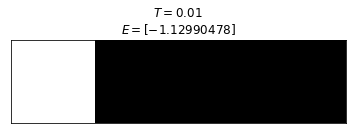

In [6]:
# your annealing code here
ising = GeneralizedIsingModel(E0, h, J, K, L)

T, _ = exp_decay_schedule(500, 100, 0.01)
animator = IsingAnimator(ising)
animator.run_animation(T)

Finally, let us iterate over the entire spin configuration space (this is tractable since we only have 4 spins) to find the exact ground state energy. Compare this energy to the one you found above using your annealer.

In [50]:
# exact ground state calculation
ising.energy(ising.all_configurations()).min()

-1.1299047752322906

Now, we loop over all hamiltonian files under the `./hamiltoniasn` folder, and calculates the energy minimum using an annealing procedure. Recall, that different hamiltonian files in this folder correspond to different separation distance between hydrogen atoms in a hydrogen molecule. Our goal is to find the miminal energy for each separation length, and compare different separation legths to see which one is the stable configuration. 

For each separation distance (each file) we will:
- Read in the associated Ising Hamiltonian
- Perform an annealed Monte Carlo simulation to find a candidate ground state energy
- Compute the exact ground state energy

In [67]:
import os
import re

files = [file for file in os.listdir('./hamiltonians') if re.match("Ising-H2.*", file)]

energies = np.zeros(len(files))
energies_exact = np.zeros(len(files))
distances = np.zeros(len(files))

for i, file in enumerate(files):
    E0, h, J, K, L = read_generalized_ising_hamiltonian('./hamiltonians/' + file)
    ising = GeneralizedIsingModel(E0, h, J, K, L)
    
    T, _ = exp_decay_schedule(500, 100, 0.001)
    E, spins = anneal(ising, T, 5)
    
    energies[i] = E
    energies_exact[i] = ising.energy(ising.all_configurations()).min()
    distances[i] = float(file[30:-4])
    
# make sure the distances are in increasing order
args = np.argsort(distances)
distances = distances[args]
energies = energies[args]
energies_exact = energies_exact[args]

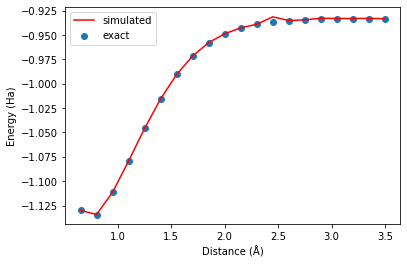

In [68]:
plt.scatter(distances, energies_exact)
plt.plot(distances, energies, color='red')
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (Ha)")
plt.legend(["simulated", "exact"])
plt.show()

First of all, as we can see the results of simulations are pretty close to the exact calculations. Secondly, the stable configuration of the atoms corresponds to interatomic distance somewhere around 0.7 Angstrom. As we know from scientific databases (such as [NIST's expermiental geometry database](https://cccbdb.nist.gov/expgeom1x.asp)), the equilibrium geometry of the hydrogen molecule corresponds to $0.74$ Angstrom. Hence the theoretical model we have discussed in this notebook is accurate.

Let us also compare the exact results calculated above with the results in `./hamiltonians/summary.dat`

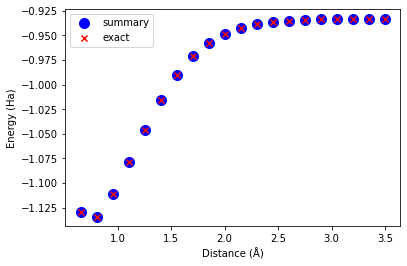

In [70]:
# compare our exact calculations with ./hamiltonians/summary.dat
with open("./hamiltonians/summary.dat", 'r') as fh:
    lines = fh.readlines()[1:]
    energies_summary = np.zeros(len(lines))
    distances_summary = np.zeros(len(lines))
    for i,line in enumerate(lines):
        distances_summary[i], energies_summary[i] = map(float, line.split())
    
    plt.scatter(distances_summary, energies_summary, marker='o', color='blue', s=100)
    plt.scatter(distances, energies_exact, marker='x', color='red')
    
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (Ha)")
plt.legend(["summary", "exact"])
plt.show()

### 2-Local Hamiltonians and Solution with Dwave

As we know, [D-Wave Systems](https://www.dwavesys.com/) builds machines for quantum annealing. In this part of the notebook let us contrast Dwave's quantum annealing with the simulated thermal annealing we have developed so far, and also implement and run analysis of hydrogen molecule against Dwave. Dwave machines can solve quadratic problems only (Quadratic Unconstrained Binary Optimization (QUBO) problems in particular). The hydrogen molecule we have seen above has a higher order hamiltonian (4th degree). To be able to run this against Dwave we need to convert it to a quadratic hamiltonian. This can be done by adding more variables to the problem as demonstrated in [this paper](https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.7b10371). 

To convert the hydrogen hamiltonian into a quadratic hamiltonian, we make use of the function `dimod.make_quadratic` from Dwave's software stack, which takes any higher order binary polynomial and converts it to a quatratic binary model. 

Let us first define a function called `poly_to_quadratic`, which takes as argument a hamiltonian filename, reads the 4th degree hamiltonian from the filename, converts it to a quadratic hamiltonian with more variables and returns the corresponding coefficients.

In [129]:
from itertools import product
import dimod

def poly_to_quadratic(filename):
    E0, h, J, K, L = read_generalized_ising_hamiltonian(filename)
    # construct poly which is recognizable by dimod.make_quadratic
    # e.g. $x_0 + 2x_0x_1 -3x_0x_2-x_0x_1x_2$ would be `{(0,): 1, (0,1): 2, (0,2): -3, (0,1,2): -1}
    poly = {}
    num_spins = len(h)
    for i in range(num_spins):
        if h[i] != 0:
            poly[(i,)] = h[i]

    for i,j in product(range(num_spins), repeat=2):
        if J[i, j] != 0:
            poly[(i, j)] = J[i, j]

    for i,j,k in product(range(num_spins), repeat=3):
        if K[i, j, k] != 0:
            poly[(i, j, k)] = K[i, j, k]

    for i,j,k,l in product(range(num_spins), repeat=4):
        if L[i, j, k, l] != 0:
            poly[(i, j, k, l)] = L[i, j, k, l]
            
    
    bqm = dimod.make_quadratic(poly, 10, dimod.SPIN)
    bqm.offset += E0
    
    # dimod.make_quadratic add new variables with string labels. Map new variable names to just integers.
    var_map = dict(zip(list(bqm.linear.keys()), range(bqm.num_variables)))
    
    E0 = bqm.offset
    h = np.array(list(bqm.linear.values()))
    J = np.zeros((bqm.num_variables, bqm.num_variables))
    for k,v in bqm.quadratic.items():
        i = var_map[k[0]]
        j = var_map[k[1]]
        J[i, j] = v / 2
        J[j, i] = v / 2
        
    return E0, h, J

There are various ways to do annealing, both physical and simulated. We have developed a framework for simulated thermal annealing and briefly talked about other possibilities in the 2nd notebook. Dwave's annealing differs from these approaches, since its idea comes from adiabatic evolution. In an adiabatic evolution procedure you start at the ground state of a simple hamiltonian, and gradually evolve into the hamiltonian of desire. According to the adiabatic theorem, if one does this transformation "slowly enough", then at the end the system will be at the ground state of the desired hamiltonian. Since "slowly enough" is usually hard to achieve, instead of adiabatic evolution Dwave does annealing, i.e. it evolves the simple hamiltonian into the desired one at some slow speed, without taking care of it beeing "slow enough", but slow enough, that the system does not hop to much higher states. At the end of the procedure sampling is done on the output state with the hope, that the ground state will appear with high probability. Below in this notebook we compare the results from such an annealing procedure with the thermal annealing.

Now we can 
1. loop over all available hamiltonian files, 
2. read them with `poly_to_quadratic` and get the corresponding quadratic hamiltonian
3. run annealing with various tools

We will run three types of optimizations this time - 1. Our simulated thermal annealing throug `GeneralizedIsingModel`, 2. Dwave, 3. exact. We do calculate the exact solutions here once again, to make sure that our quadratic model does indeed correctly represent the hydrogen molecule (we expect, that the exact solutitons here be the same, as we have obtained above).

In [121]:
import neal

energies_dwave = np.zeros(len(files))
energies_quad = np.zeros(len(files))
energies_exact_quad = np.zeros(len(files))

for i,file in enumerate(files):
    E0, h, J = poly_to_quadratic("./hamiltonians/" + file)

    bqm = dimod.BinaryQuadraticModel(h, J, E0, dimod.SPIN)
    sampler = neal.SimulatedAnnealingSampler()
    energies_dwave[i] = sampler.sample(bqm, num_reads=100).lowest().first.energy
    
    n = h.shape[0]
    ising = GeneralizedIsingModel(E0, h, J, np.zeros((n, n, n)), np.zeros((n, n, n, n)))
    T, _ = exp_decay_schedule(500, 100, 0.01)
    E, _ = anneal(ising, T, 1)
    energies_quad[i] = E
    
    energies_exact_quad[i] = ising.energy(ising.all_configurations()).min()
    
energies_dwave = energies_dwave[args]
energies_quad = energies_quad[args]
energies_exact_quad = energies_exact_quad[args]

Let us plot the results for exact calculation and Dwav against the exact calculations from the 4th degree model above. As we can see the exact calculations throught the binary model perfectly match the ones from the 4th degree model, which means our conversion from 4th order to quadratic is correct. We can also see, that Dwaves's simulated quantum annealing does an extremely good job at predicting the energies.

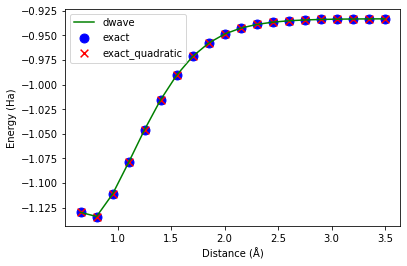

In [132]:
plt.plot(distances, energies_dwave, color='green')
plt.scatter(distances, energies_exact, marker='o', color='blue', s=80)
plt.scatter(distances, energies_exact_quad, marker='x', color='red', s=60)
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (Ha)")
plt.legend(["dwave", "exact", 'exact_quadratic'])
plt.show()

Let us now look at the results from our thermal annealing. As we can see the results are very bad. At some distances the thermal annealing has been able to find the global minimum and match with the exact results, however in general it gets stuck at local minimums and produces overall useless results. While the conversion from higher order models to quadratic ones is possible, and works well with e.g. quantum annealing and simulated quantum annealing, it introduces a lot of local minimums in the energy landscape of the system, and makes difficult for simulated thermal annealing to work.

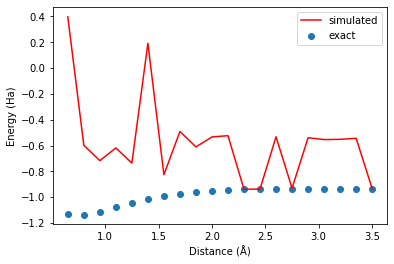

In [133]:
plt.scatter(distances, energies_exact)
plt.plot(distances, energies_quad, color='red')
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (Ha)")
plt.legend(["simulated", "exact"])
plt.show()